In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
inflows = pd.read_parquet('data/ucsd-inflows.pqt')
outflows = pd.read_parquet('data/ucsd-outflows.pqt')

display(inflows.head(), outflows.head())

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


In [3]:
outflows.posted_date = pd.to_datetime(outflows.posted_date)

For purposes described later, I create a subset of `outflows` that doesn't include rows where `memo == category`

In [4]:
outflows_with_memo = outflows[~(outflows.memo == outflows.category)].reset_index().drop(columns='index')
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


## WEEK 2 - Train Test Split

#### Splitting by the transaction

In [5]:
from sklearn.model_selection import train_test_split

test_size = 0.25

inflows_train, inflows_test = train_test_split(inflows, test_size=test_size, random_state=42)
outflows_train, outflows_test = train_test_split(outflows, test_size=test_size, random_state=42)

#### Need to sample by consumer instead of transaction

In [6]:
# Get unique customer_ids
ids = outflows.prism_consumer_id.unique()
ids_memo = outflows_with_memo.prism_consumer_id.unique()

# Split customer_ids into training and testing sets
train_ids, test_ids = train_test_split(ids, test_size=0.25)
train_ids_memo, test_ids_memo = train_test_split(ids_memo, test_size=0.25)

I am building two sets of data because a large proportion of the `outflows` dataset has the category given in the memo. For the purposes of training, I make a second train and test set without those rows: `outflows_memo_train` and `outflows_memo_test` which is built from `outflows_with_memo`

In [7]:
outflows_train = outflows[outflows['prism_consumer_id'].isin(train_ids)]
outflows_test = outflows[outflows['prism_consumer_id'].isin(test_ids)]

outflows_memo_train = outflows_with_memo[outflows_with_memo['prism_consumer_id'].isin(train_ids_memo)]
outflows_memo_test = outflows_with_memo[outflows_with_memo['prism_consumer_id'].isin(test_ids_memo)]

In [8]:
outflows_train.shape, outflows_test.shape

((1966870, 6), (630618, 6))

In [9]:
outflows_memo_train.shape, outflows_memo_test.shape

((981215, 6), (325237, 6))

For the entire outflows dataset

In [10]:
print(f'# of unique IDS: {len(outflows.prism_consumer_id.unique())}, # of unique train IDS: {len(outflows_train.prism_consumer_id.unique())}, # of unique test IDS: {len(outflows_test.prism_consumer_id.unique())}')

# of unique IDS: 2968, # of unique train IDS: 2226, # of unique test IDS: 742


For the subset of outflows that doesn't have the category given in the memo

In [11]:
print(f'# of unique IDS: {len(outflows_with_memo.prism_consumer_id.unique())}, # of unique train IDS: {len(outflows_memo_train.prism_consumer_id.unique())}, # of unique test IDS: {len(outflows_memo_test.prism_consumer_id.unique())}')

# of unique IDS: 2952, # of unique train IDS: 2214, # of unique test IDS: 738


In [12]:
outflows.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,2597488.00000,2597488.00000,2597488.00000
mean,3084.22934,145.12640,.5f
min,0.00000,0.00000,.5f
25%,1369.00000,9.63000,.5f
50%,3245.00000,24.26000,.5f
75%,4733.00000,66.36000,.5f
max,5943.00000,654853.21000,.5f
std,1820.57135,1697.87473,nan


In [13]:
outflows_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,1966870.00000,1966870.00000,1966870.00000
mean,3092.39911,148.03919,.5f
min,0.00000,0.00000,.5f
25%,1369.00000,9.58000,.5f
50%,3295.00000,24.10000,.5f
75%,4731.00000,66.12000,.5f
max,5943.00000,654853.21000,.5f
std,1819.07559,1827.24434,nan


In [14]:
outflows_test.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,630618.00000,630618.00000,630618.00000
mean,3058.74816,136.04152,.5f
min,21.00000,0.00000,.5f
25%,1350.00000,9.78000,.5f
50%,3089.00000,24.75000,.5f
75%,4745.00000,67.01000,.5f
max,5928.00000,218402.00000,.5f
std,1824.99525,1208.42603,nan


#### TODO include statistical tests to ensure distributions are similar

## WEEK 3 - Memo Cleaning

In [15]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


#### Memo cleaning steps:
- did more complex preprocessing first 
    - lemmatizer? (might not be good for this because it could stem words it shouldn't
    - same thing for stop words
    - remove dates (regex search mm/yy) and location addresses
    - get rid of email addresses -- TODO 
    - trans 1 @ $1.00 -- TODO
- simple preprocessing
    - lowercase 
    - remove punctuation (,-*#_')
    - remove XXXX, even amount of X's
    - remove purchase authorized on
    - remove purchase, checkcard
- should not preprocess memos that are the same category

In [16]:
outflows.category.unique()

array(['LOAN', 'ATM_CASH', 'FOOD_AND_BEVERAGES', 'ENTERTAINMENT',
       'GENERAL_MERCHANDISE', 'ESSENTIAL_SERVICES', 'GROCERIES',
       'EXTERNAL_TRANSFER', 'AUTOMOTIVE', 'UNCATEGORIZED',
       'CREDIT_CARD_PAYMENT', 'SELF_TRANSFER', 'PETS',
       'HEALTHCARE_MEDICAL', 'INSURANCE', 'ACCOUNT_FEES',
       'HOME_IMPROVEMENT', 'TRAVEL', 'MORTGAGE', 'OVERDRAFT', 'EDUCATION',
       'RENT', 'TAX', 'CHILD_DEPENDENTS', 'GIFTS_DONATIONS',
       'BILLS_UTILITIES', 'PAYCHECK', 'BNPL', 'AUTO_LOAN'], dtype=object)

In [17]:
memos = outflows_with_memo.memo

In [18]:
memos[memos.str.contains('@')].values[:1000]

array(['CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX',
       'Autoplicity LL support@autop',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | 

In [19]:
pattern1 = r'\b\w*x{2,}\w*\b'
pattern2 = r'\b(0[1-9]|1[0-2])(\/|-)[0-9]{2}\b'
pattern3 = r"[,'*#_-]"

In [20]:
cleaned_memos = (
    memos.str.lower()
        .str.replace(pattern1, '', regex=True)                   # removing XXXX                        
        .str.replace(pattern2, '', regex=True)                   # removing dates
        .str.replace(pattern3, '', regex=True)                   # removing unnecessary special characters
        .str.replace(r'~', '', regex=True)                       # removing ~ (can't include in character class above)
        .str.replace('purchase.* authorized on', '', regex=True) # removing common phrase
        .str.replace('checkcard', '')                            # removing common phrase
        .str.strip()                                             # removing leading and trailing characters
)

In [21]:
cleaned_memos = cleaned_memos.reset_index().drop(columns='index').squeeze()

In [22]:
outflows_with_memo['cleaned_memo'] = cleaned_memos

In [23]:
# looking at 
test = memos.str.replace(r'trans \d+ @ \$\d+\.\d{2}', 'testing', regex=True)
test[(test.str.contains('@'))].values[:1000]

array(['CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX',
       'Autoplicity LL support@autop',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | 

In [24]:
memos[(memos.str.contains('@'))].values[:1000]

array(['CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'PURCHASE XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX SCBJJ* SCBJJ dknakagawa@gmCA XXXXXXXXXXXXXXXXXXXXXXX RECURRING',
       'CHECKCARD XXXX GSUITE_besmer. cc@google.comCA XXXXXXXXXXXXXXXXXXXXXXX',
       'Autoplicity LL support@autop',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | JUDITH WISWELL ATTY @LXXXXXXXXXXXX',
       'MERCHANT BNKCD | FEE / | 

In [25]:
memos.unique().__len__(), cleaned_memos.unique().__len__(), 

(528766, 307409)

In [26]:
memos_counts = memos.value_counts()
cleaned_memos_counts = cleaned_memos.value_counts()

In [27]:
memos_counts

memo
Amazon                                                                               31725
Walmart                                                                              31619
McDonald's                                                                           22670
Starbucks                                                                            12777
7-Eleven                                                                             11675
                                                                                     ...  
Doordash Kazu Sushi Bu                                                                   1
Par Gators Dockside -                                                                    1
Chilis Mandarin                                                                          1
Chilis Bay Meadows                                                                       1
POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS RD MESA AZ  Card 15 #XXXX  MCC XXXX    

In [28]:
cleaned_memos_counts

memo
walmart                                                          32099
amazon                                                           31737
mcdonalds                                                        27598
starbucks                                                        12823
7eleven                                                          11821
                                                                 ...  
lobby bar lake charles la  card                                      1
total wine and friendswood tx  card                                  1
victoria bridal houston tx  card                                     1
liquor hu  fm  baytown tx  card                                      1
pos withdrawalwalmart   e mckellips rd mesa az  card 15   mcc        1
Name: count, Length: 307409, dtype: int64

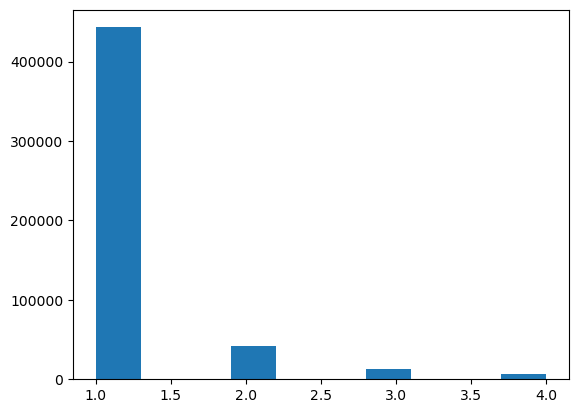

In [29]:
plt.hist(memos_counts[memos_counts < 5])
plt.show()

In [30]:
(memos_counts == 1).sum()

443287

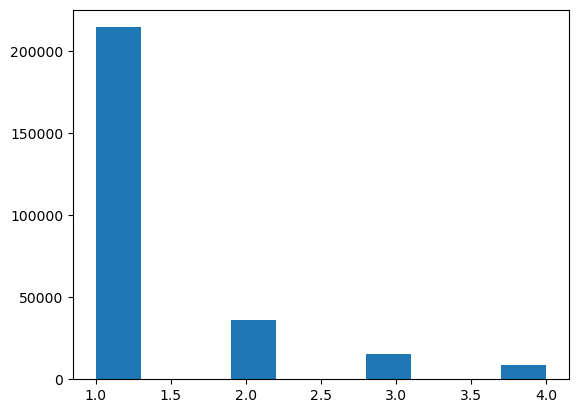

In [31]:
plt.hist(cleaned_memos_counts[cleaned_memos_counts < 5])
plt.show()

In [32]:
(cleaned_memos_counts == 1).sum()

214737

## Week 4

In [33]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,cleaned_memo
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES,tst casa del rio exp fairlawn oh
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE,oculus ca
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow oh
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1 oh


### Creating Features

#### TF-IDF

- Currently looking at the top 50 words by term frequency

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [124]:
vectorizer = TfidfVectorizer(max_features=50)
tfidf = vectorizer.fit_transform(cleaned_memos)

In [159]:
vectorizer_2 = TfidfVectorizer(max_features=1000, max_df=0.85)
tfidf_2 = vectorizer_2.fit_transform(cleaned_memos)

In [160]:
vectorizer_2.get_feature_names_out()

array(['00', '000', '001', '01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18',
       '185', '19', '1infiniteloop', '20', '201', '21', '22', '228', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '340', '35', '36', '365', '38', '39', '40', '41', '42', '43',
       '432', '43232', '432329', '46', '50', '51', '52', '53', '54',
       '7eleven', '800', '800782', '800782728', '888', '99', 'aa', 'abc',
       'academy', 'accnt', 'acct', 'ace', 'ach', 'acme', 'activity',
       'adobe', 'adt', 'afterpay', 'air', 'airport', 'al', 'albert',
       'albertsons', 'albuquerque', 'aldi', 'allsups', 'alma', 'alus',
       'am', 'amazon', 'american', 'ames', 'amzn', 'an', 'ana', 'anaheim',
       'and', 'angeles', 'animal', 'anna', 'antonio', 'apex', 'app',
       'apple', 'applebees', 'appreed', 'ar', 'aramark', 'arbys',
       'arlington', 'army', 'asian', 'at', 'atlanta', 'atm', 'audible',


In [37]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)
tfidf_df.columns = vectorizer.get_feature_names_out()

In [148]:
tfidf_df_2 = pd.DataFrame.sparse.from_spmatrix(tfidf_2)
tfidf_df_2 = vectorizer_2.get_feature_names_out()

#### Dates and Amounts

In [38]:
outflows.category.unique()

array(['LOAN', 'ATM_CASH', 'FOOD_AND_BEVERAGES', 'ENTERTAINMENT',
       'GENERAL_MERCHANDISE', 'ESSENTIAL_SERVICES', 'GROCERIES',
       'EXTERNAL_TRANSFER', 'AUTOMOTIVE', 'UNCATEGORIZED',
       'CREDIT_CARD_PAYMENT', 'SELF_TRANSFER', 'PETS',
       'HEALTHCARE_MEDICAL', 'INSURANCE', 'ACCOUNT_FEES',
       'HOME_IMPROVEMENT', 'TRAVEL', 'MORTGAGE', 'OVERDRAFT', 'EDUCATION',
       'RENT', 'TAX', 'CHILD_DEPENDENTS', 'GIFTS_DONATIONS',
       'BILLS_UTILITIES', 'PAYCHECK', 'BNPL', 'AUTO_LOAN'], dtype=object)

**Date Features**
- month of year -- charges change by month (increase in food_and_beverages in summer, general_merchandise during holidays, travel)
- day of week -- charges change by day (weekend may see more food spending, weekday for groceries)
- day of month -- beginning of month charges (rent) vs middle of month charges (utilities) vs end of month (credit card?)

In [39]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
posted_date = outflows_with_memo.posted_date

In [41]:
date_features = pd.DataFrame()
date_features['month'] = 'month_' + posted_date.dt.month.astype(str)
date_features['weekday'] = 'weekday_' + posted_date.dt.weekday.astype(str)
date_features['day_of_month'] = 'day_of_month_' + posted_date.dt.day.astype(str)

In [42]:
date_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
date_enc.fit(date_features)

OneHotEncoder(drop='first', handle_unknown='ignore')

In [43]:
date_enc.categories_

[array(['month_1', 'month_10', 'month_11', 'month_12', 'month_2',
        'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
        'month_9'], dtype=object),
 array(['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
        'weekday_5', 'weekday_6'], dtype=object),
 array(['day_of_month_1', 'day_of_month_10', 'day_of_month_11',
        'day_of_month_12', 'day_of_month_13', 'day_of_month_14',
        'day_of_month_15', 'day_of_month_16', 'day_of_month_17',
        'day_of_month_18', 'day_of_month_19', 'day_of_month_2',
        'day_of_month_20', 'day_of_month_21', 'day_of_month_22',
        'day_of_month_23', 'day_of_month_24', 'day_of_month_25',
        'day_of_month_26', 'day_of_month_27', 'day_of_month_28',
        'day_of_month_29', 'day_of_month_3', 'day_of_month_30',
        'day_of_month_31', 'day_of_month_4', 'day_of_month_5',
        'day_of_month_6', 'day_of_month_7', 'day_of_month_8',
        'day_of_month_9'], dtype=object)]

In [44]:
date_one_hot = date_enc.transform(date_features)

**Amount Features**
- is even amount (x.00)
- bin the amounts based on size
    - potentially by category as well?

In [45]:
amount = outflows_with_memo.amount

In [46]:
amount_features = pd.DataFrame()
amount_features['is_even'] = amount.apply(lambda x: 'amount_even' if x % 1 == 0 else 'amount_odd')
amount_features['decile_amounts'] = pd.qcut(amount, q=10, labels=['decile_0', 'decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9'])

In [47]:
amount_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
amount_enc.fit(amount_features)

OneHotEncoder(drop='first', handle_unknown='ignore')

In [48]:
amount_enc.categories_

[array(['amount_even', 'amount_odd'], dtype=object),
 array(['decile_0', 'decile_1', 'decile_2', 'decile_3', 'decile_4',
        'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9'],
       dtype=object)]

In [49]:
amount_one_hot = amount_enc.transform(amount_features)

### Putting Features Together

In [87]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=[f'tfidf_{feature}' for feature in vectorizer.get_feature_names_out()])

date_columns = np.concatenate([feature[1:] for feature in date_enc.categories_])
date_one_hot_df = pd.DataFrame.sparse.from_spmatrix(date_one_hot, columns=date_columns)

amount_columns = np.concatenate([feature[1:] for feature in amount_enc.categories_])
amount_one_hot_df = pd.DataFrame.sparse.from_spmatrix(amount_one_hot, columns=amount_columns)

In [161]:
tfidf_df_2 = pd.DataFrame.sparse.from_spmatrix(tfidf_2, columns=[f'tfidf_{feature}' for feature in vectorizer_2.get_feature_names_out()])


In [88]:
outflows_features = pd.concat([outflows_with_memo, tfidf_df, date_one_hot_df, amount_one_hot_df], axis=1)

In [162]:
outflows_features_2 = pd.concat([outflows_with_memo, tfidf_df_2, date_one_hot_df, amount_one_hot_df], axis=1)

In [89]:
# Get unique customer_ids
ids_memo = outflows_features.prism_consumer_id.unique()

# Split customer_ids into training and testing sets
train_ids_memo, test_ids_memo = train_test_split(ids_memo, test_size=0.25)

In [90]:
outflows_features_train = outflows_features[outflows_features['prism_consumer_id'].isin(train_ids_memo)]
outflows_features_test = outflows_features[outflows_features['prism_consumer_id'].isin(test_ids_memo)]

In [171]:
outflows_features_train_2 = outflows_features_2[outflows_features_2['prism_consumer_id'].isin(train_ids_memo)]
outflows_features_test_2 = outflows_features_2[outflows_features_2['prism_consumer_id'].isin(test_ids_memo)]

In [91]:
outflows_features_train.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,cleaned_memo,tfidf_21,tfidf_22,tfidf_7eleven,...,amount_odd,decile_1,decile_2,decile_3,decile_4,decile_5,decile_6,decile_7,decile_8,decile_9
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES,tst casa del rio exp fairlawn oh,0,0,0,...,1.0,0,0,0,1.0,0,0,0,0,0
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings,0,0,0,...,1.0,0,0,0,0,0,1.0,0,0,0
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE,oculus ca,0,0,0,...,1.0,0,0,1.0,0,0,0,0,0,0
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow oh,0,0,0,...,1.0,0,0,0,0,0,1.0,0,0,0
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1 oh,0,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0


In [138]:
outflows_features_2.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,cleaned_memo,tfidf_00,tfidf_000,tfidf_001,...,amount_odd,decile_1,decile_2,decile_3,decile_4,decile_5,decile_6,decile_7,decile_8,decile_9
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES,tst casa del rio exp fairlawn oh,0,0,0,...,1.0,0,0,0,1.0,0,0,0,0,0
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings,0,0,0,...,1.0,0,0,0,0,0,1.0,0,0,0
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE,oculus ca,0,0,0,...,1.0,0,0,1.0,0,0,0,0,0,0
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow oh,0,0,0,...,1.0,0,0,0,0,0,1.0,0,0,0
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1 oh,0,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0


In [92]:
X_train = outflows_features_train.iloc[:, 7:]
y_train = outflows_features_train['category']
X_test = outflows_features_test.iloc[:, 7:]
y_test = outflows_features_test['category']

In [172]:
X_train_2 = outflows_features_train_2.iloc[:, 7:]
y_train_2 = outflows_features_train_2['category']
X_test_2 = outflows_features_test_2.iloc[:, 7:]
y_test_2 = outflows_features_test_2['category']

In [93]:
print(X_train.columns[:50])

Index(['tfidf_21', 'tfidf_22', 'tfidf_7eleven', 'tfidf_amazon', 'tfidf_amzn',
       'tfidf_apple', 'tfidf_authorized', 'tfidf_az', 'tfidf_bill', 'tfidf_ca',
       'tfidf_card', 'tfidf_cash', 'tfidf_check', 'tfidf_circle', 'tfidf_co',
       'tfidf_com', 'tfidf_date', 'tfidf_debit', 'tfidf_dollar',
       'tfidf_doordash', 'tfidf_fl', 'tfidf_food', 'tfidf_ga', 'tfidf_google',
       'tfidf_id', 'tfidf_il', 'tfidf_in', 'tfidf_market', 'tfidf_mcdonalds',
       'tfidf_mktp', 'tfidf_ny', 'tfidf_of', 'tfidf_on', 'tfidf_payment',
       'tfidf_point', 'tfidf_pos', 'tfidf_pur', 'tfidf_purchase',
       'tfidf_recurring', 'tfidf_san', 'tfidf_starbucks', 'tfidf_target',
       'tfidf_the', 'tfidf_tx', 'tfidf_uber', 'tfidf_us', 'tfidf_visa',
       'tfidf_wa', 'tfidf_walmart', 'tfidf_withdrawal'],
      dtype='object')


In [94]:
print(X_train.columns[51:])

Index(['month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'day_of_month_10',
       'day_of_month_11', 'day_of_month_12', 'day_of_month_13',
       'day_of_month_14', 'day_of_month_15', 'day_of_month_16',
       'day_of_month_17', 'day_of_month_18', 'day_of_month_19',
       'day_of_month_2', 'day_of_month_20', 'day_of_month_21',
       'day_of_month_22', 'day_of_month_23', 'day_of_month_24',
       'day_of_month_25', 'day_of_month_26', 'day_of_month_27',
       'day_of_month_28', 'day_of_month_29', 'day_of_month_3',
       'day_of_month_30', 'day_of_month_31', 'day_of_month_4',
       'day_of_month_5', 'day_of_month_6', 'day_of_month_7', 'day_of_month_8',
       'day_of_month_9', 'amount_odd', 'decile_1', 'decile_2', 'decile_3',
       'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9'],
      dtype='object')


In [95]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [96]:
y_train.unique().__len__()

9

In [97]:
y_test.unique().__len__()

9

In [98]:
outflows_with_memo.category.unique()

array(['FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE', 'GROCERIES', 'PETS',
       'TRAVEL', 'MORTGAGE', 'OVERDRAFT', 'EDUCATION', 'RENT'],
      dtype=object)

In [99]:
outflows.category.unique()

array(['LOAN', 'ATM_CASH', 'FOOD_AND_BEVERAGES', 'ENTERTAINMENT',
       'GENERAL_MERCHANDISE', 'ESSENTIAL_SERVICES', 'GROCERIES',
       'EXTERNAL_TRANSFER', 'AUTOMOTIVE', 'UNCATEGORIZED',
       'CREDIT_CARD_PAYMENT', 'SELF_TRANSFER', 'PETS',
       'HEALTHCARE_MEDICAL', 'INSURANCE', 'ACCOUNT_FEES',
       'HOME_IMPROVEMENT', 'TRAVEL', 'MORTGAGE', 'OVERDRAFT', 'EDUCATION',
       'RENT', 'TAX', 'CHILD_DEPENDENTS', 'GIFTS_DONATIONS',
       'BILLS_UTILITIES', 'PAYCHECK', 'BNPL', 'AUTO_LOAN'], dtype=object)

### Training Models

#### Logistic Regression

In [100]:
from sklearn.linear_model import LogisticRegression

In [173]:
log_reg_2 = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1).fit(X_train_2, y_train_2) 

In [101]:
log_reg = LogisticRegression(max_iter=200, random_state=0).fit(X_train, y_train) 

In [102]:
coef_df = pd.DataFrame(log_reg.coef_, columns=X_train.columns, index=log_reg.classes_)

In [103]:
for i in range(len(coef_df)):
    display(coef_df.iloc[i].abs().sort_values(ascending=False).iloc[:10])

tfidf_of           2.196553
tfidf_point        1.648115
tfidf_com          1.509371
tfidf_card         1.333332
tfidf_az           1.331550
tfidf_date         1.307831
tfidf_recurring    1.182278
tfidf_cash         1.159171
tfidf_co           1.140759
tfidf_san          1.082774
Name: EDUCATION, dtype: float64

tfidf_starbucks    7.383752
tfidf_mcdonalds    7.176111
tfidf_walmart      6.787753
tfidf_target       4.916845
tfidf_doordash     4.657794
tfidf_google       3.953286
tfidf_amzn         3.729407
tfidf_circle       3.297760
tfidf_bill         3.048384
tfidf_dollar       2.199233
Name: FOOD_AND_BEVERAGES, dtype: float64

tfidf_google       7.473211
tfidf_amzn         7.003467
tfidf_amazon       6.553721
tfidf_dollar       6.364897
tfidf_uber         5.204485
tfidf_7eleven      4.482036
tfidf_cash         4.344199
tfidf_apple        4.088091
tfidf_circle       4.021719
tfidf_starbucks    3.740611
Name: GENERAL_MERCHANDISE, dtype: float64

tfidf_walmart      8.580708
tfidf_target       7.090128
tfidf_market       5.373211
tfidf_food         4.085558
tfidf_uber         3.475599
tfidf_dollar       2.901507
tfidf_mcdonalds    2.551526
tfidf_amazon       2.458059
tfidf_google       2.244113
tfidf_point        2.201825
Name: GROCERIES, dtype: float64

decile_9            3.898143
tfidf_payment       3.724873
tfidf_bill          3.492453
tfidf_withdrawal    3.168198
tfidf_card          2.458415
tfidf_id            2.187501
tfidf_us            1.798111
tfidf_debit         1.512312
tfidf_purchase      1.422465
tfidf_pos           1.312654
Name: MORTGAGE, dtype: float64

tfidf_card        4.771944
tfidf_date        4.276304
tfidf_point       3.315092
amount_odd        2.872767
tfidf_id          2.822730
tfidf_purchase    2.672691
tfidf_ca          2.533462
tfidf_debit       2.522988
decile_6          2.304625
tfidf_fl          2.270775
Name: OVERDRAFT, dtype: float64

tfidf_com          2.530025
decile_8           2.390319
tfidf_recurring    1.894620
decile_7           1.849577
decile_6           1.757299
tfidf_card         1.513609
decile_5           1.475071
tfidf_point        1.443015
tfidf_wa           1.440023
decile_4           1.312589
Name: PETS, dtype: float64

tfidf_id          2.587173
tfidf_card        2.568219
tfidf_on          2.497918
tfidf_ca          2.103637
tfidf_com         1.878046
decile_2          1.779694
tfidf_co          1.684945
tfidf_purchase    1.528813
decile_6          1.401372
tfidf_az          1.321749
Name: RENT, dtype: float64

tfidf_uber       8.906625
tfidf_food       2.920764
tfidf_walmart    2.439490
tfidf_7eleven    2.335217
tfidf_payment    2.225146
tfidf_target     2.152164
tfidf_market     1.847099
tfidf_bill       1.482237
tfidf_ca         1.473188
tfidf_card       1.403673
Name: TRAVEL, dtype: float64

In [104]:
log_preds_train = log_reg.predict(X_train)
log_preds_test = log_reg.predict(X_test)

In [174]:
log_preds_train_2 = log_reg_2.predict(X_train_2)
log_preds_test_2 = log_reg_2.predict(X_test_2)

**Overall accuracy**

In [105]:
f"Train accuracy: {(log_preds_train == y_train).mean()}, Test accuracy: {(log_preds_test == y_test).mean()}"

'Train accuracy: 0.7097761274768972, Test accuracy: 0.6999247011000985'

In [175]:
f"Train accuracy: {(log_preds_train_2 == y_train_2).mean()}, Test accuracy: {(log_preds_test_2 == y_test_2).mean()}"

'Train accuracy: 0.9126648117792834, Test accuracy: 0.8986464563603083'

**Accuracy by category**

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [107]:
# 9x9 confusion matrix for accuracy per class, normalized over predictions (sees how often the predictions are correct)
conf_matrix = confusion_matrix(y_train, log_preds_train, labels=y_train.unique(), normalize='pred')
classes = y_train.value_counts().sort_values(ascending=False).index
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

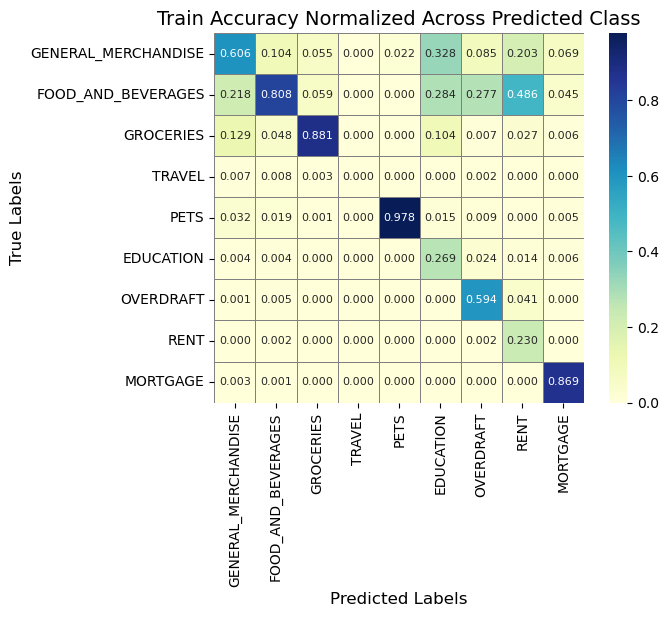

In [108]:
sns.heatmap(conf_matrix_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
            linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8})

plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Train Accuracy Normalized Across Predicted Class", fontsize=14)
plt.show()

In [109]:
# 9x9 confusion matrix for accuracy per class, normalized over predictions (sees how often the predictions are correct)
conf_matrix = confusion_matrix(y_test, log_preds_test, labels=y_test.unique(), normalize='pred')
classes = y_test.value_counts().sort_values(ascending=False).index
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

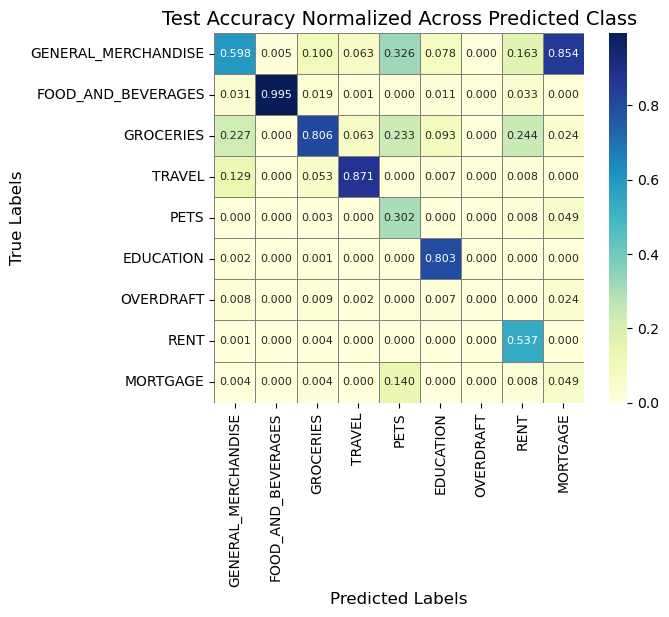

In [110]:
sns.heatmap(conf_matrix_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
            linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8})

plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Test Accuracy Normalized Across Predicted Class", fontsize=14)
plt.show()

In [111]:
y_train.value_counts().sort_values(ascending=False)

category
GENERAL_MERCHANDISE    391971
FOOD_AND_BEVERAGES     361173
GROCERIES              164673
TRAVEL                  45994
PETS                     6767
EDUCATION                3378
OVERDRAFT                2585
RENT                     2496
MORTGAGE                  717
Name: count, dtype: int64

#### Gradient Boosting (XGBoost)

In [112]:
# !pip install xgboost

In [113]:
from xgboost import XGBClassifier

In [114]:
XGBClassifier?

Init signature:
XGBClassifier(
    *,
    objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : Optional[int]
        Number of boosting rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: Favors splitting at nodes with highest loss change.

    learning_rate : typing.Optional[float

In [115]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [116]:
# hyperparameters to consider: n_estimators, max_depth, learning_rate
bst = XGBClassifier(objective='multi:softmax')
bst.fit(X_train, y_train_encoded)

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [117]:
preds_train_encoded = bst.predict(X_train)
preds_test_encoded = bst.predict(X_test)

bst_preds_train = le.inverse_transform(preds_train_encoded)
bst_preds_test = le.inverse_transform(preds_test_encoded)

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


In [118]:
f"Train accuracy: {(bst_preds_train == y_train).mean()}, Test accuracy: {(bst_preds_test == y_test).mean()}"

'Train accuracy: 0.7338382900197397, Test accuracy: 0.7043477462365855'

In [119]:
# 'Train accuracy: 0.7301464661398314, Test accuracy: 0.7111407249466951' ------ basic xgboost

In [120]:
# 9x9 confusion matrix for accuracy per class, normalized over predictions (sees how often the predictions are correct)
conf_matrix = confusion_matrix(y_train, bst_preds_train, labels=y_train.unique(), normalize='pred')
classes = y_train.value_counts().sort_values(ascending=False).index
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

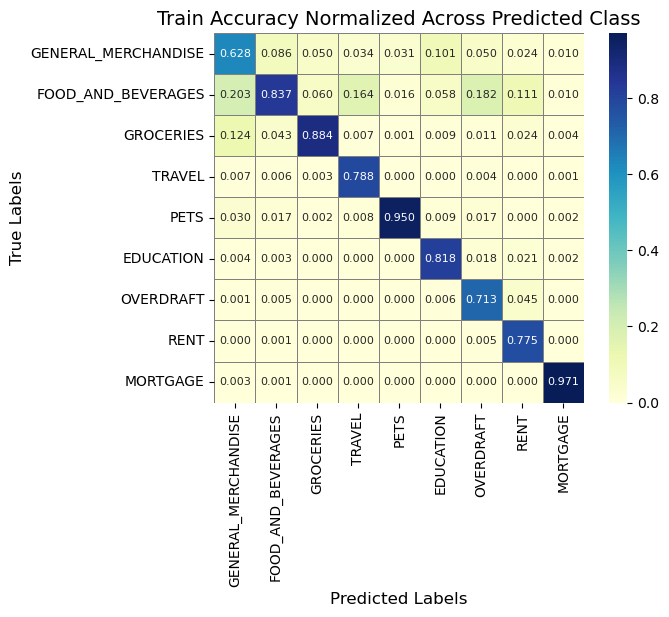

In [121]:
sns.heatmap(conf_matrix_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
            linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8})

plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Train Accuracy Normalized Across Predicted Class", fontsize=14)
plt.show()

In [122]:
# 9x9 confusion matrix for accuracy per class, normalized over predictions (sees how often the predictions are correct)
conf_matrix = confusion_matrix(y_test, bst_preds_test, labels=y_test.unique(), normalize='pred')
classes = y_test.value_counts().sort_values(ascending=False).index
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

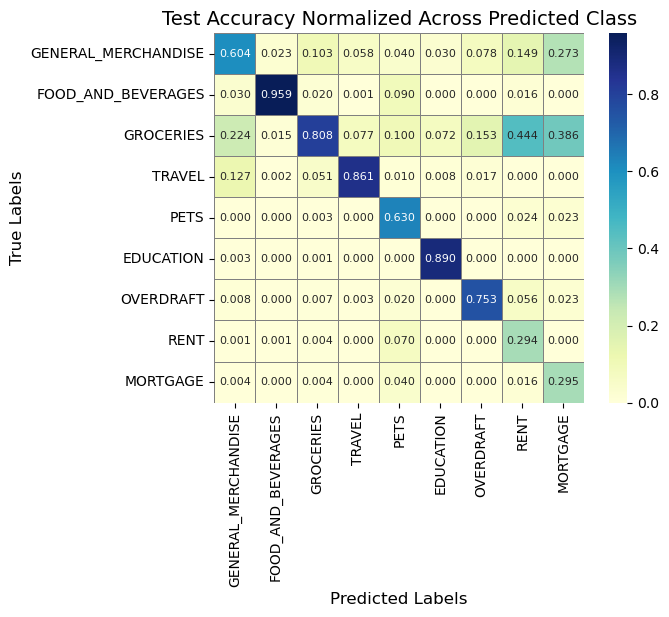

In [123]:
sns.heatmap(conf_matrix_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
            linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8})

plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Test Accuracy Normalized Across Predicted Class", fontsize=14)
plt.show()